In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from scipy import stats

In [ ]:
august_data = pd.read_csv('/content/drive/MyDrive/TLC_Yellow/yellow_tripdata_2023-08.csv', parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])
september_data = pd.read_csv('/content/drive/MyDrive/TLC_Yellow/yellow_tripdata_2023-09.csv', parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])

combined_data = pd.concat([august_data, september_data], ignore_index=True)

<ipython-input-5-7fdac8a53f39>:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  august_data = pd.read_csv('/content/drive/MyDrive/TLC_Yellow/yellow_tripdata_2023-08.csv', parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])
<ipython-input-5-7fdac8a53f39>:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  september_data = pd.read_csv('/content/drive/MyDrive/TLC_Yellow/yellow_tripdata_2023-09.csv', parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])


In [ ]:
selected_features = ['trip_distance', 'RatecodeID', 'fare_amount','payment_type', 'Airport_fee', 'tip_amount']

taxi_filtered = combined_data[selected_features]

taxi_filtered['pickup_weekday'] = combined_data['tpep_pickup_datetime'].dt.weekday
taxi_filtered['pickup_hour'] = combined_data['tpep_pickup_datetime'].dt.hour
taxi_filtered['pickup_week_hour'] = (taxi_filtered['pickup_weekday'] * 24) + taxi_filtered['pickup_hour']
taxi_filtered['pickup_minute'] = combined_data['tpep_pickup_datetime'].dt.minute

taxi_filtered['dropoff_weekday'] = combined_data['tpep_dropoff_datetime'].dt.weekday
taxi_filtered['dropoff_hour'] = combined_data['tpep_dropoff_datetime'].dt.hour
taxi_filtered['dropoff_week_hour'] = (taxi_filtered['dropoff_weekday'] * 24) + taxi_filtered['dropoff_hour']
taxi_filtered['dropoff_minute'] = combined_data['tpep_dropoff_datetime'].dt.minute

def remove_outliers_zscore(df, columns):
    z_scores = stats.zscore(df[columns])
    abs_z_scores = abs(z_scores)
    filtered_entries = (abs_z_scores < 3).all(axis=1)
    return df[filtered_entries]
columns_to_check = ['trip_distance', 'fare_amount']
taxi_filtered_no_outliers = remove_outliers_zscore(taxi_filtered, columns_to_check)

label_encoders = {}
categorical_columns = ['RatecodeID', 'payment_type','Airport_fee']

for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    taxi_filtered_no_outliers[col] = label_encoders[col].fit_transform(taxi_filtered_no_outliers[col])

X = taxi_filtered_no_outliers.drop('tip_amount', axis=1)
y = taxi_filtered_no_outliers['tip_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

<ipython-input-7-b735b3722efb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taxi_filtered['pickup_weekday'] = combined_data['tpep_pickup_datetime'].dt.weekday
<ipython-input-7-b735b3722efb>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taxi_filtered['pickup_hour'] = combined_data['tpep_pickup_datetime'].dt.hour
<ipython-input-7-b735b3722efb>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [ ]:
def data_sampling(taxi_filtered):
    sample = taxi_filtered.sample(9999)
    return sample

In [ ]:
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer)

with tf.device('/GPU:0'):
    history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=8196, validation_split=0.2, verbose=1)

loss = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {loss}")

predictions = model.predict(X_test_scaled)
predictions_df = pd.DataFrame({'True Values': y_test.values, 'Predictions': predictions.flatten()})
sample = data_sampling(predictions_df)

Epoch 1/50
388/388 [==============================] - 14s 11ms/step - loss: 8.7141 - val_loss: 6.5504
Epoch 2/50
388/388 [==============================] - 3s 8ms/step - loss: 6.6128 - val_loss: 6.3832
Epoch 3/50
388/388 [==============================] - 2s 5ms/step - loss: 6.4307 - val_loss: 6.3426
Epoch 4/50
388/388 [==============================] - 2s 5ms/step - loss: 6.3575 - val_loss: 6.4078
Epoch 5/50
388/388 [==============================] - 2s 5ms/step - loss: 6.3123 - val_loss: 6.3059
Epoch 6/50
388/388 [==============================] - 2s 6ms/step - loss: 6.2777 - val_loss: 6.3018
Epoch 7/50
388/388 [==============================] - 4s 11ms/step - loss: 6.2573 - val_loss: 6.3115
Epoch 8/50
388/388 [==============================] - 3s 9ms/step - loss: 6.2416 - val_loss: 6.3124
Epoch 9/50
388/388 [==============================] - 3s 7ms/step - loss: 6.2147 - val_loss: 6.4838
Epoch 10/50
388/388 [==============================] - 3s 7ms/step - loss: 6.2043 - val_loss: 6.4

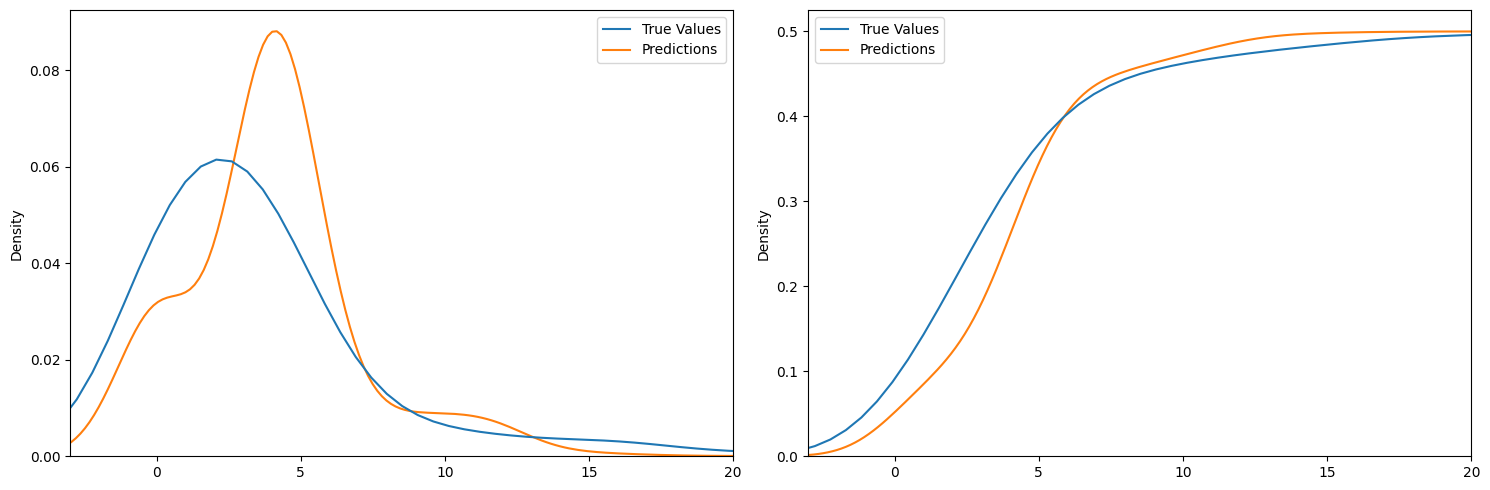

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].set(xlim=[-3, 20])
axs[1].set(xlim=[-3, 20])

sns.kdeplot(data=sample, ax=axs[0], bw_adjust=3)
sns.kdeplot(data=sample, ax=axs[1], bw_adjust=3, cumulative=True)

fig.tight_layout()

In [ ]:
print(taxi_filtered_no_outliers.info())
print(taxi_filtered_no_outliers.describe())
print(taxi_filtered_no_outliers.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5670178 entries, 0 to 5670930
Data columns (total 14 columns):
 #   Column             Dtype  
---  ------             -----  
 0   trip_distance      float64
 1   RatecodeID         int64  
 2   fare_amount        float64
 3   payment_type       int64  
 4   Airport_fee        int64  
 5   tip_amount         float64
 6   pickup_weekday     int64  
 7   pickup_hour        int64  
 8   pickup_week_hour   int64  
 9   pickup_minute      int64  
 10  dropoff_weekday    int64  
 11  dropoff_hour       int64  
 12  dropoff_week_hour  int64  
 13  dropoff_minute     int64  
dtypes: float64(3), int64(11)
memory usage: 648.9 MB
None
       trip_distance    RatecodeID   fare_amount  payment_type   Airport_fee  \
count   5.670178e+06  5.670178e+06  5.670178e+06  5.670178e+06  5.670178e+06   
mean    3.552810e+00  4.000710e-01  2.010128e+01  1.187945e+00  1.307321e+00   
std     4.704921e+00  1.490626e+00  1.928603e+01  5.749371e-01  8.036970e-01 

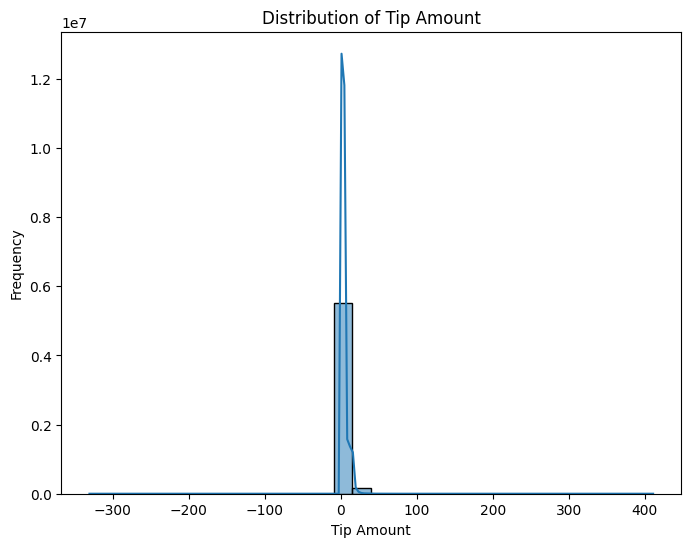

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(taxi_filtered_no_outliers['tip_amount'], bins=30, kde=True)
plt.xlabel('Tip Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Tip Amount')
plt.show()

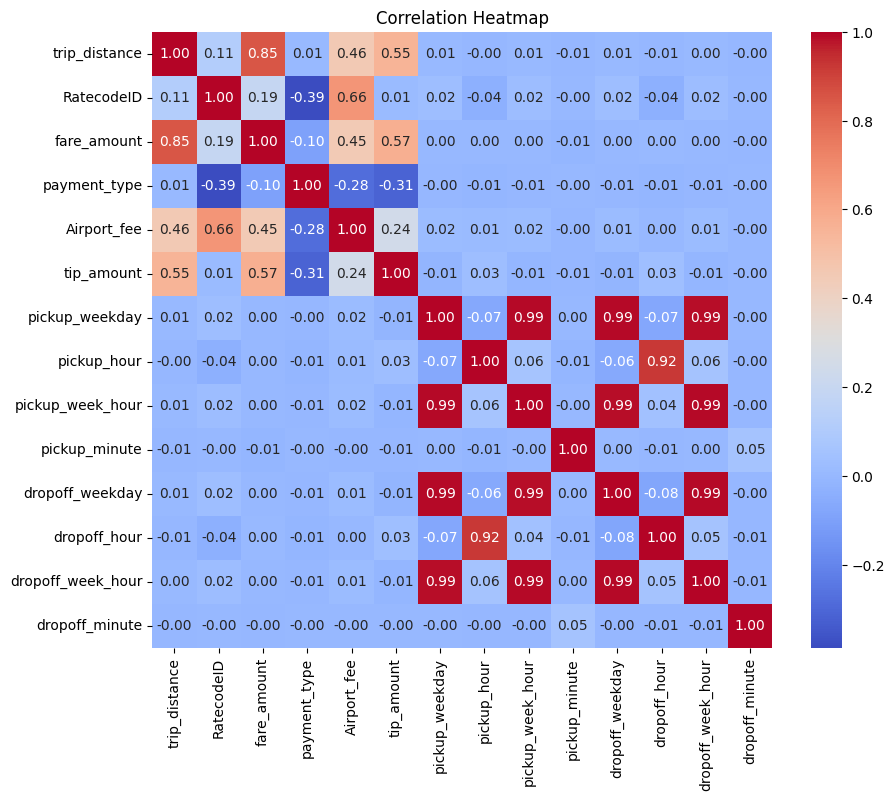

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(taxi_filtered_no_outliers.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

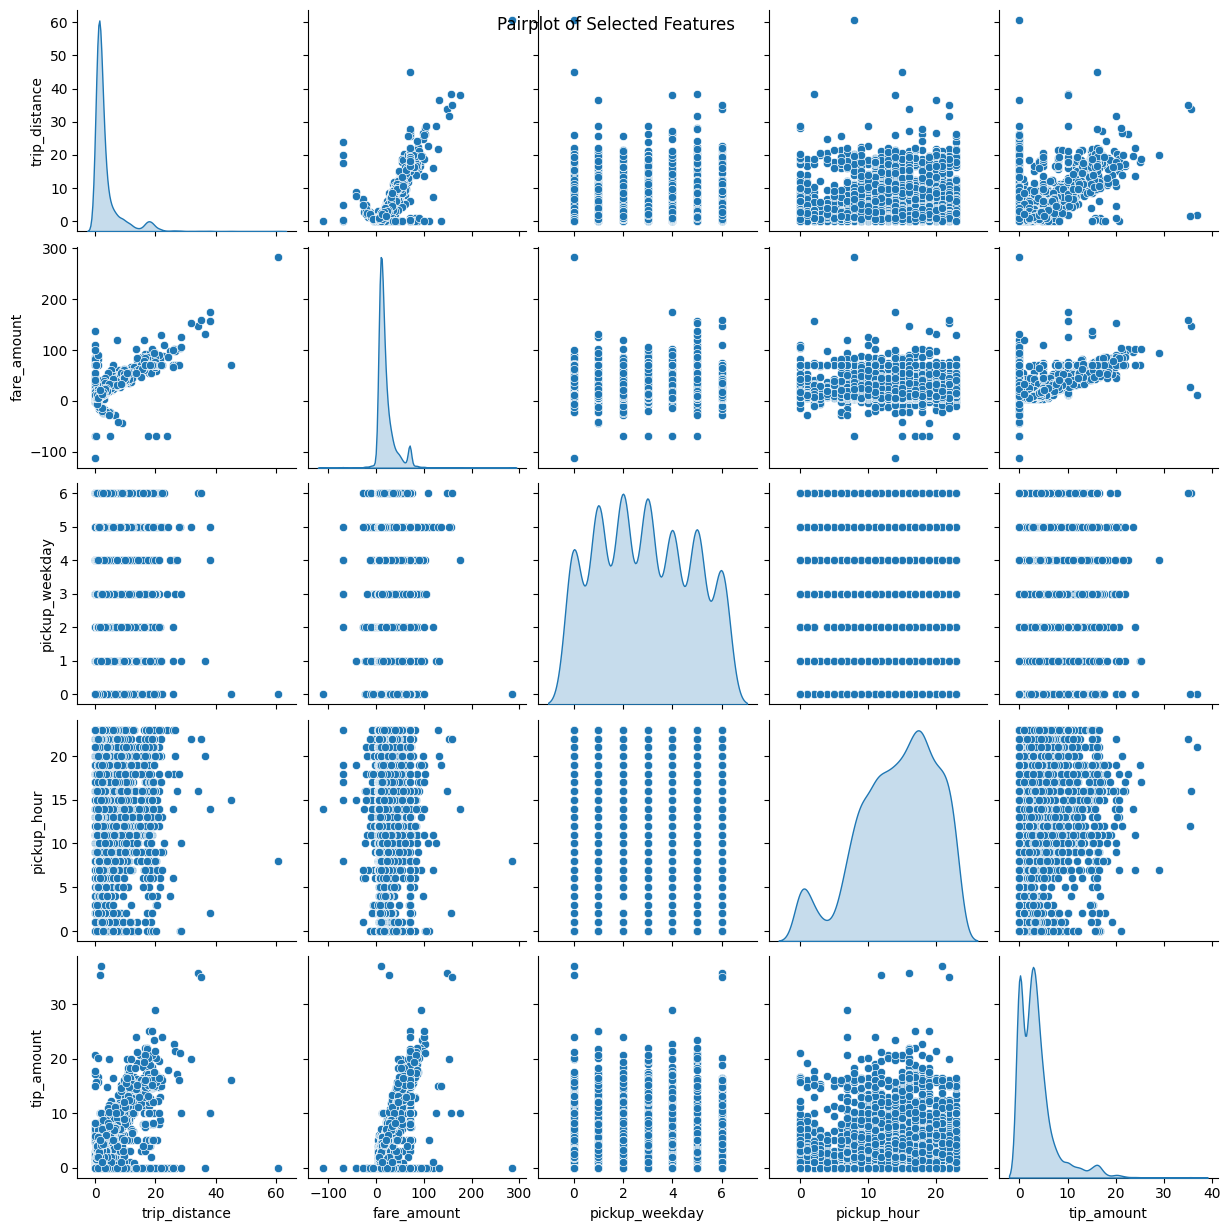

In [ ]:
sns.pairplot(taxi_filtered_no_outliers.sample(5000), vars=['trip_distance', 'fare_amount', 'pickup_weekday', 'pickup_hour', 'tip_amount'], diag_kind='kde')
plt.suptitle('Pairplot of Selected Features')
plt.show()

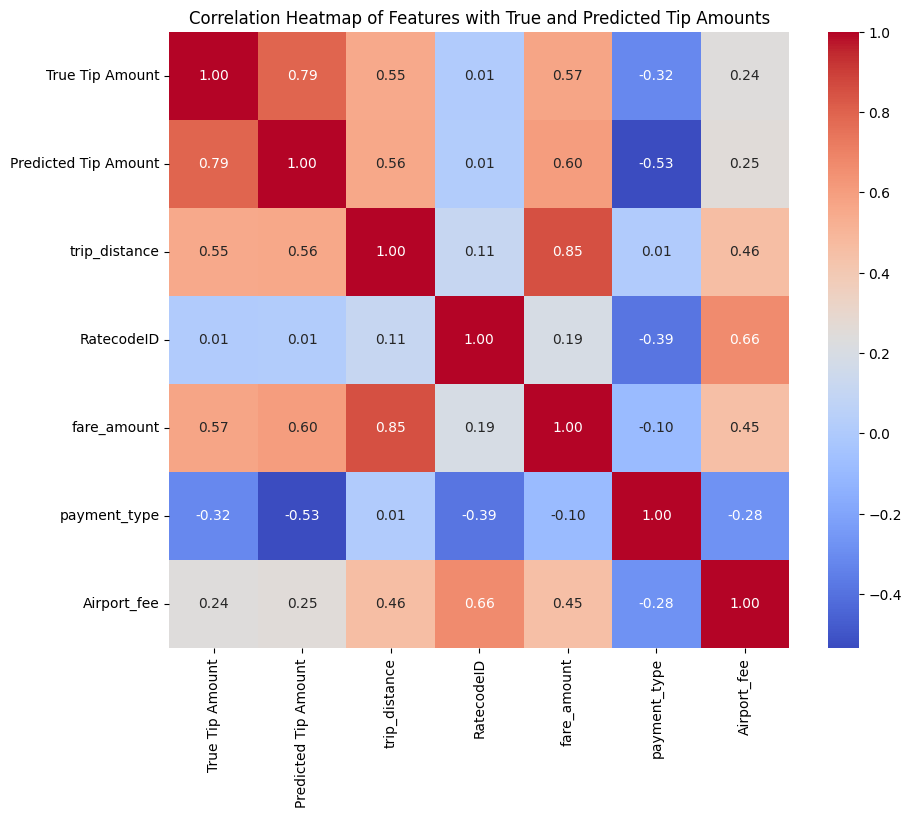

In [ ]:
selected_features_without_tip = [feature for feature in selected_features if feature != 'tip_amount']

comparison_df = pd.DataFrame({
    'True Tip Amount': y_test.values,
    'Predicted Tip Amount': predictions.flatten()
})
comparison_df[selected_features_without_tip] = X_test.reset_index(drop=True)[selected_features_without_tip]

correlation_matrix = comparison_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Features with True and Predicted Tip Amounts')
plt.show()

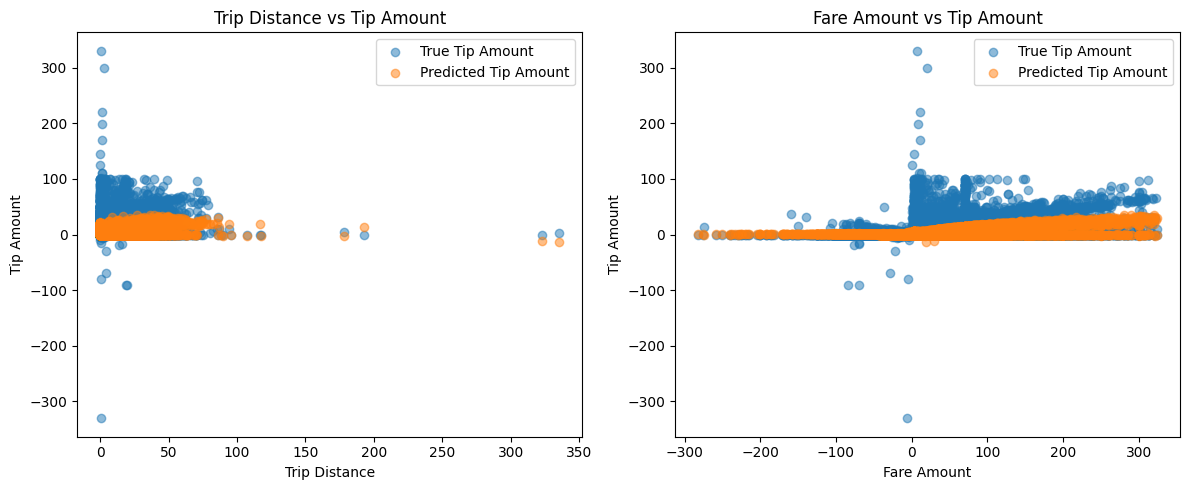

In [ ]:
visualization_df = pd.DataFrame({
    'Trip Distance': X_test['trip_distance'],
    'Fare Amount': X_test['fare_amount'],
    'True Tip Amount': y_test.values,
    'Predicted Tip Amount': predictions.flatten()
})

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(visualization_df['Trip Distance'], visualization_df['True Tip Amount'], label='True Tip Amount', alpha=0.5)
plt.scatter(visualization_df['Trip Distance'], visualization_df['Predicted Tip Amount'], label='Predicted Tip Amount', alpha=0.5)
plt.xlabel('Trip Distance')
plt.ylabel('Tip Amount')
plt.title('Trip Distance vs Tip Amount')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(visualization_df['Fare Amount'], visualization_df['True Tip Amount'], label='True Tip Amount', alpha=0.5)
plt.scatter(visualization_df['Fare Amount'], visualization_df['Predicted Tip Amount'], label='Predicted Tip Amount', alpha=0.5)
plt.xlabel('Fare Amount')
plt.ylabel('Tip Amount')
plt.title('Fare Amount vs Tip Amount')
plt.legend()

plt.tight_layout()
plt.show()